In [1]:
import warnings
warnings.filterwarnings('ignore')
import string
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd

from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet, stopwords

import time
import pickle

In [ ]:
"""
    RUN IF NEEDED
"""

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [2]:
def set_size(SIZE = 20):
    """
        This function make label, legend, title of matplotlib.pyplot bigger (more readable)
    """
    
    plt.rc('font', size=SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SIZE)    # legend fontsize
    plt.rc('figure', titlesize=SIZE)

# 1. Exploratory Data Analysis

In [3]:
data = pd.read_csv('yelp.csv', usecols = ['text', 'stars'])
print('There are {} reviews'.format(data.shape[0]))
data.head()

There are 10000 reviews


,stars,text
0,5,My wife took me here on my birthday for breakf...
1,5,I have no idea why some people give bad review...
2,4,love the gyro plate. Rice is so good and I als...
3,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!..."
4,5,General Manager Scott Petello is a good egg!!!...


In [4]:
print(data.iloc[100]['stars'])
print('----')
print(data.iloc[100]['text'])

4
----
I have to admit that I find myself thinking that I like mine tall dark and Russian. 

 It's nice to have a coffee shop near by that's not Starbucks, has good coffee and reasonable prices.  So far I just stick with the house brew (which is smooth and not too bitter yet not too sweet) since the fancy coffee drinks usually have many calories that I do not need!  I have tried the blueberry muffin-quite yummy as well as the chocolate chip cookies- delicious.  The cafe is attached to The Great Indoors so you can people watch, browse thru design books or take a leisurely stroll through the design center.  It's a great way to unwind or perk up on your choice of caffeinated beverage.


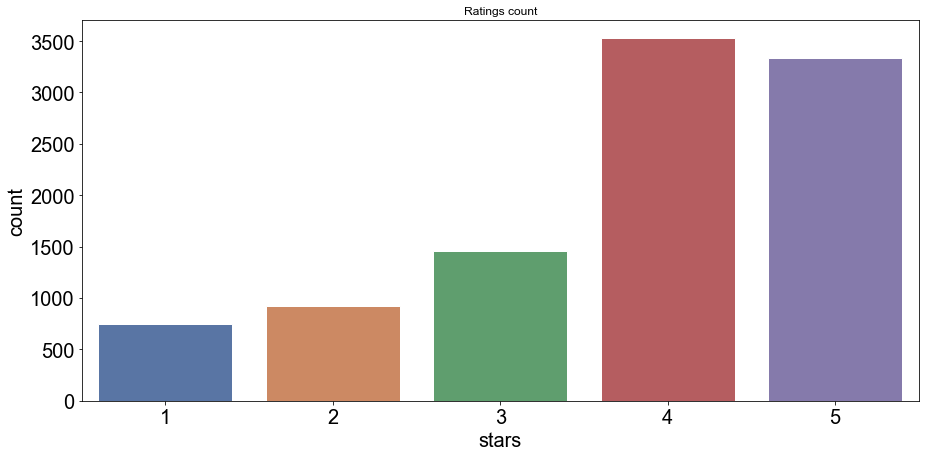

In [5]:
set_size()
plt.subplots(figsize=(15,7))
sns.set(style="darkgrid")
sns.countplot(x=data['stars'])
plt.title('Ratings count')
plt.show()

* This is unbalanced dataset ! I didn't tackle this issue.
* Since we want to do a sentiment classifier, I decided to drop 3-stars reviews and consider {1,2} star as negative review and {4,5} star as positive review.

In [6]:
def filter_stars(star):
    if star >= 4 : return 1
    elif star <= 2 : return 0
    else : return -1

In [7]:
data['label'] = data['stars'].map(filter_stars)
data = data[data['label'] >= 0]
data = data[['label', 'text']]

print('After filtering, there are {} reviews'.format(data.shape[0]))

After filtering, there are 8539 reviews


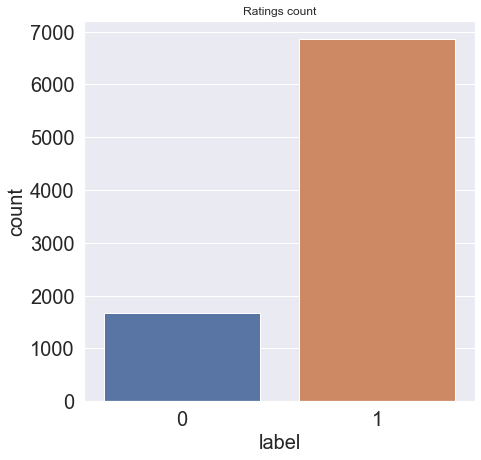

In [8]:
set_size()
plt.subplots(figsize=(7,7))
sns.set(style="darkgrid")
sns.countplot(x=data['label'])
plt.title('Ratings count')
plt.show()

In [9]:
data.label.value_counts(normalize=True)

1    0.803724
0    0.196276
Name: label, dtype: float64

In [10]:
"Study length of reviews"

data['length'] = data['text'].map(lambda x : len(x.split()))

In [11]:
data.length.describe()

count    8539.000000
mean      129.384237
std       113.054562
min         1.000000
25%        52.000000
50%        99.000000
75%       171.000000
max       945.000000
Name: length, dtype: float64

The minimum length is 1 and the maximum one is 945. For this `simple` model, I decided to take the reviews which have the length between 10 and 300

In [12]:
MIN_LENGTH = 10
MAX_LENGTH = 300

print('Before dropping, there are {} reviews'.format(data.shape[0]))

data = data[(data['length']>=MIN_LENGTH) & (data['length']<=MAX_LENGTH)]

print('After filtering, there are {} reviews'.format(data.shape[0]))

Before dropping, there are 8539 reviews
After filtering, there are 7675 reviews


In [13]:
data.label.value_counts(normalize=True)

1    0.812899
0    0.187101
Name: label, dtype: float64

In [14]:
def plot_term_frequency(df, col, n_terms):
    set_size()
    terms = []
    for texts in df[col]:
        for text in texts.split():
            terms.append(text)

    plt1 = pd.Series(terms).value_counts().sort_values(ascending=False)[:n_terms].to_frame()
    sns.barplot(plt1[0],plt1.index,palette=sns.color_palette('inferno_r',n_terms))
    plt.title('Top tags frequency')
    fig=plt.gcf()
    fig.set_size_inches(20,15)
    plt.show()

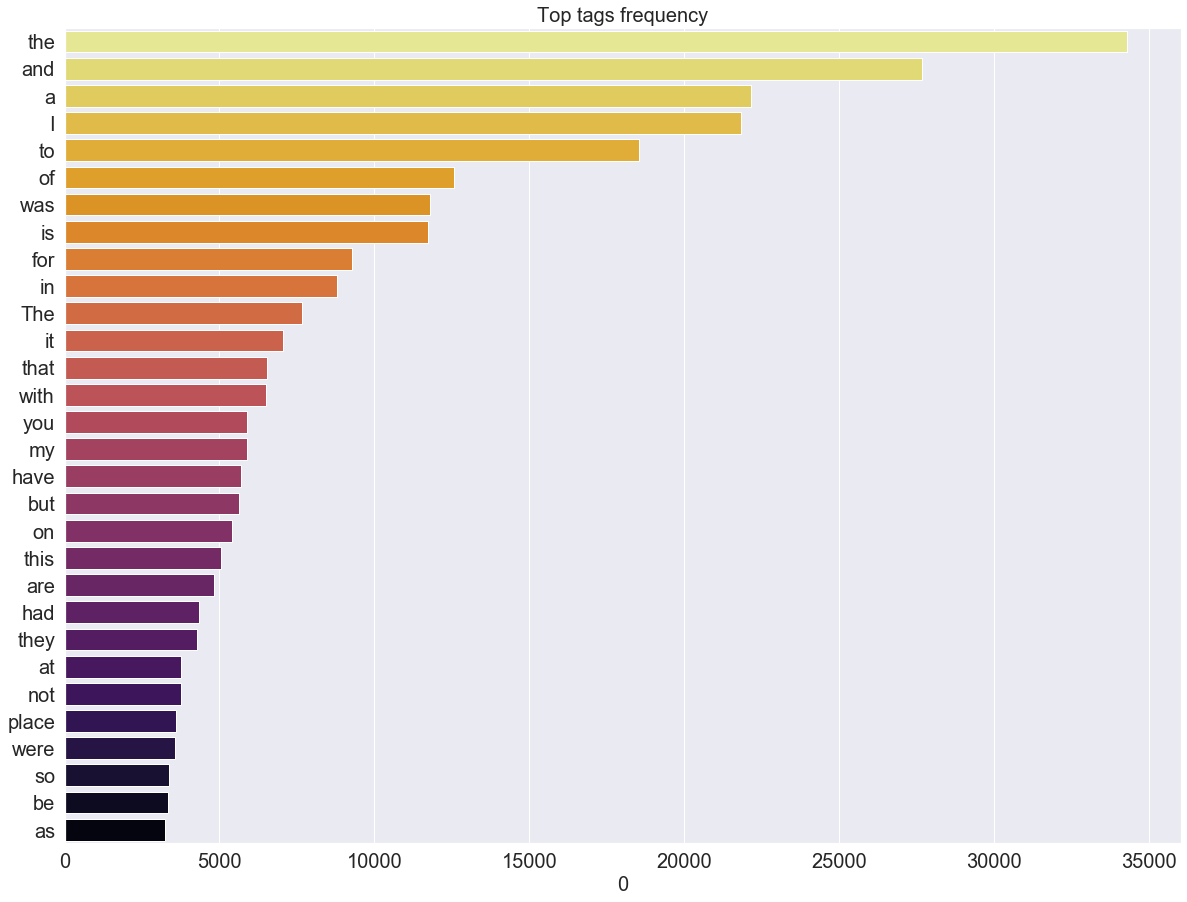

In [15]:
plot_term_frequency(data, 'text', n_terms=30)

# 2. Preprocessing reviews

* Since we do not have any GPU resources for training. I decided NOT to use any deep learning models like RNNs, LSTM, Transformer...
* Thus, for preprocessing reviews, I apply traditional NLP techniques: Standardize, Tokenize, POS tagging, Stopwords removing.

In [16]:
PUNCTUATION = string.punctuation

RE_HASHTAG = r'#\S+' #hashtags
RE_AT = r'@\S+'      #@
RE_NB = " \d+"       #numbers
UNK = ""             

In [17]:
def standardize_text(sentence):
    """
        Standardize sentence
    """
    
    sentence = sentence.replace("can't", "can not").replace("n't", " not")\
                       .replace("\\n"," ").replace("\n", " ")\
                       .replace("\'", " ").replace("-"," ")\
                       .replace("_"," ").replace('"', " ")
    
    for x in PUNCTUATION:
        sentence = sentence.replace(x , " ")
    
    sentence = re.sub(RE_HASHTAG, UNK, sentence)
    sentence = re.sub(RE_AT     , UNK, sentence)
    sentence = re.sub(RE_NB     , UNK, sentence)
    
    sentence = sentence.lower()
    
    return sentence

In [18]:
"""
    POS - TAGGING
"""

def get_wordnet_pos(treebank_tag):
    """Map ['NN', 'NNS', 'NNP', 'NNPS'] to NOUN....."""
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [19]:
lemmatiser = WordNetLemmatizer()
stop = stopwords.words('english')
stop.remove('not')
tokenizer = RegexpTokenizer(r'\w+')

def processing_sentence(sentence):
    
    "Standardize"
    sentence = standardize_text(sentence)
    
    "Tokenization"
    sentence = tokenizer.tokenize(sentence)
    
    "Lemmatization"
    tokens_pos = pos_tag(sentence)
    tokens_pos = [(w,get_wordnet_pos(p)) for (w,p) in tokens_pos]
    sentence = [lemmatiser.lemmatize(w, pos=p) for (w,p) in tokens_pos if p != None]
    
    "Stopwords removing"
    sentence = [x for x in sentence if x not in stop ]
    
    return ' '.join(sentence)

In [20]:
def processing_text(text):
    new_sentences = ''
    for sentence in text.split('.'):
        new_sentences += processing_sentence(sentence)
        new_sentences += ' '
    return new_sentences

In [21]:
start_time = time.time()

processed_text = []
for i in range(data.shape[0]):
    processed_text.append(processing_text(data.iloc[i]['text']))

data['processed_text'] = processed_text

print("Processed all text take {} seconds".format(time.time() - start_time))

Processed all text take 49.51225686073303 seconds


In [22]:
data.head()

,label,text,length,processed_text
0,1,My wife took me here on my birthday for breakf...,155,wife take birthday breakfast excellent weather...
1,1,I have no idea why some people give bad review...,257,idea people give bad review place go show plea...
2,1,love the gyro plate. Rice is so good and I als...,16,love gyro plate rice good also dig candy selec...
3,1,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",76,rosie dakota love chaparral dog park convenien...
4,1,General Manager Scott Petello is a good egg!!!...,86,general manager scott petello good egg not go ...


In [23]:
"""
    EXAMPLE
"""

print(data.iloc[100]['text'])


print('----------------------------------------')
print('----------------------------------------')
print('----------------------------------------')


print(data.iloc[100]['processed_text'])

I have had a great experience every time I have been there.  The food is hard to beat and the service was pleasant.  

Portions are reasonable, not huge (I'm a big feller), and I was satified every time I ate there.  

Very pleasant environment, clean, spacious and calm.
----------------------------------------
----------------------------------------
----------------------------------------
great experience time food hard beat service pleasant portion reasonable not huge big feller satified time eat pleasant environment clean spacious calm  


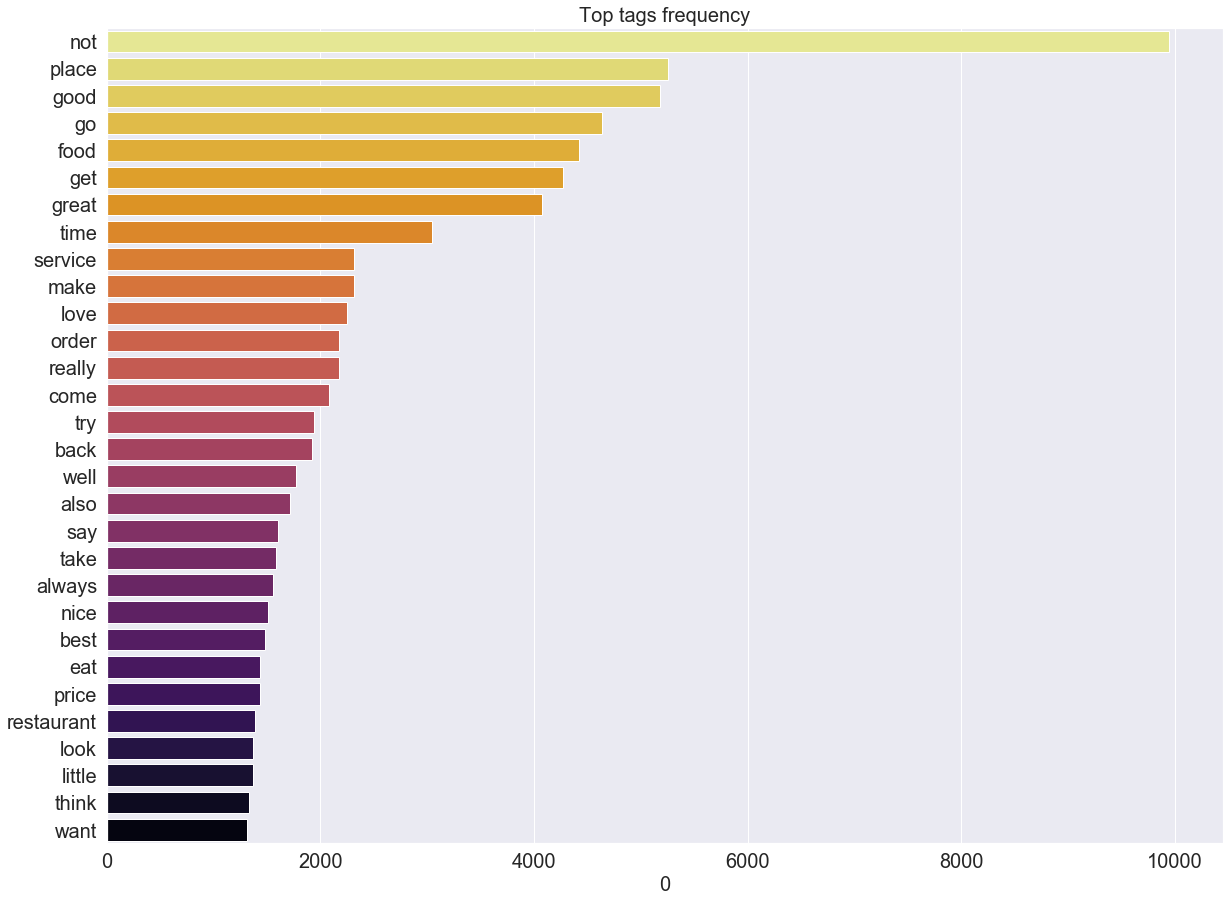

In [24]:
plot_term_frequency(data, 'processed_text', n_terms=30)

# 3. Feature generating and Modeling

In [25]:
"Data spliting"

train, test = train_test_split(data, test_size=0.2)

In [26]:
"""
    Choose TFIDF as feature for reviews. 
    Consider only words that appear in at least 3 reviews

"""
tfidf_vectorizer = TfidfVectorizer(min_df=3)

In [27]:
train_tfidf = tfidf_vectorizer.fit_transform(train['processed_text'])
test_tfidf = tfidf_vectorizer.transform(test['processed_text'])

train_tfidf.shape, test_tfidf.shape

((6140, 6612), (1535, 6612))

* train_tfidf: matrix of 6140 reviews and 6657 words (vocabulary size)
* test_tfidf:  matrix of 1535 reviews and 6657 words

In [28]:
"Vocabulary"

tfidf_vectorizer.get_feature_names()[:15]

['aa',
 'aaron',
 'ab',
 'abandon',
 'ability',
 'able',
 'aboutam',
 'aboutpm',
 'absent',
 'absolute',
 'absolutely',
 'absurd',
 'abuelo',
 'abundance',
 'ac']

### Support vector machine model

In [29]:
cls = svm.SVC(kernel='linear')
cls.fit(train_tfidf, train['label'])

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [30]:
y_pred = cls.predict(test_tfidf)

In [31]:
print("Accuracy:", metrics.accuracy_score (test['label'], y_pred))
print("Precision:",metrics.precision_score(test['label'], y_pred))
print("Recall:",   metrics.recall_score   (test['label'], y_pred))
print("F1:",       metrics.f1_score   (test['label'], y_pred))

Accuracy: 0.9166123778501629
Precision: 0.9254518072289156
Recall: 0.9769475357710652
F1: 0.9505027068832173


Since we have an unbalanced dataset. It's is better to user AUC metric

In [32]:
print("AUC:", metrics.roc_auc_score(test['label'], y_pred))

AUC: 0.8097734068747023


In [33]:
def get_sentiment(sentence):
    processed_sentence = processing_text(sentence)
    tfidf = tfidf_vectorizer.transform([processed_sentence])
    return cls.predict(tfidf)[0]

In [34]:
TEST = "This a is bad place to eat"

get_sentiment(TEST)

0

In [35]:
TEST = "This a is good place to eat"

get_sentiment(TEST)

1

In [36]:
TEST = "I do not like this place"

get_sentiment(TEST)

0

In [37]:
"""
    Save models
"""

CLASSIFIER_MODEL = 'flask-app/models/cls.pickle'
TFIDF_VECTORIZER = 'flask-app/models/tfidf.pickle'

pickle.dump(cls, open(CLASSIFIER_MODEL, 'wb'))
pickle.dump(tfidf_vectorizer, open(TFIDF_VECTORIZER, 'wb'))